**Lab2-DL: A6-MNIST-CNN.ipynb** (ELMED219) | Prioritet: 1 (kjerne)

_MNIST-klassifisering med konvolusjonelt nevralt nettverk (CNN) – state-of-the-art_

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/A6-MNIST-CNN.ipynb)

Sist oppdatert: 2025-12-04, A. Lundervold

Bruk `elmed219-2026` conda-miljøet eller Google Colab

---

## Målet nådd: CNN – den ultimate bildeklassifikatoren

### Læringsreisen fullført!

```
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│  A4: Random     │    │  A5: MLP        │    │  A6: CNN        │
│  Forest         │ →  │  (Nevrale nett) │ →  │  (Dyp læring)   │
│ ≈92% nøyaktighet│    │ ≈97% nøyaktighet│    │ ≈99% nøyaktighet│
└─────────────────┘    └─────────────────┘    └─────────────────┘
     BASELINE              FORBEDRING        ▶▶ DU ER HER ◀◀
```

### Hvorfor CNN revolusjonerte medisinsk bildeanalyse

**Konvolusjonelle nettverk** (CNN) er designet for å *se* bilder slik vi gjør:

| Problem | MLP | CNN |
|---------|-----|-----|
| Romlig struktur | ❌ Ignorerer naboskap | ✅ Utnytter lokale mønstre |
| Parametertall | 784×100 = 78 400 | 3×3×32 = 288 (første lag) |
| Translasjonsinvarians | ❌ Siffer må være sentrert | ✅ Finner siffer uansett posisjon |
| Hierarkisk læring | ❌ Flate representasjoner | ✅ Lag 1: kanter → Lag 2: former → Lag 3: siffer |

### Medisinsk anvendelse

CNN brukes i dag til:
- 🫁 **Røntgen-analyse**: Pneumoni, COVID-19
- 🧠 **MR/CT**: Tumor-segmentering, Alzheimer-prediksjon
- 👁️ **Retina-bilder**: Diabetisk retinopati
- 🔬 **Histopatologi**: Kreftdiagnostikk

> 💡 **Nøkkelpunkt**: CNN lærer automatisk hvilke visuelle features som er viktige – ingen manuell feature engineering!

In [14]:
# === Sjekk kjøremiljø ===

try:
    import google.colab
    ER_COLAB = True
    print("✅ Kjører i Google Colab")
except ImportError:
    ER_COLAB = False
    print("💻 Kjører lokalt")

import torch
if torch.cuda.is_available():
    print(f"🚀 GPU tilgjengelig: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print("🍎 Apple Silicon MPS tilgjengelig")
else:
    print("💻 Kjører på CPU")

💻 Kjører lokalt
🍎 Apple Silicon MPS tilgjengelig


---

## 1. Importer og forberedelser

In [15]:
# === Importer nødvendige biblioteker ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import platform

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Lightning
try:
    import lightning.pytorch as pl
    from lightning.pytorch import Trainer
except ImportError:
    import pytorch_lightning as pl
    from pytorch_lightning import Trainer

# Scikit-learn for evaluering
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Plattform-spesifikk num_workers
NUM_WORKERS = 0 if platform.system() == 'Darwin' else 4

print("✅ Alle biblioteker lastet inn")
print(f"   PyTorch versjon: {torch.__version__}")

✅ Alle biblioteker lastet inn
   PyTorch versjon: 2.6.0


---

## 2. Last inn MNIST-data

Vi laster data som tensorer direkte – CNN forventer 4D-input: `[batch, kanaler, høyde, bredde]`

In [27]:
# === Last inn MNIST som tensorer ===

data_mappe = Path('mnist_data')
data_mappe.mkdir(exist_ok=True)

# Prøv komprimert fil først
gzip_fil = data_mappe / 'mnist_20000bilder.csv.gz'
csv_fil = data_mappe / 'mnist_20000bilder.csv'

if gzip_fil.exists():
    print(f"📂 Laster data fra: {gzip_fil}")
    mnist_data = pd.read_csv(gzip_fil)
elif csv_fil.exists():
    mnist_data = pd.read_csv(csv_fil)
else:
    print("⏳ Genererer MNIST-data fra PyTorch...")
    from torchvision import datasets, transforms
    
    mnist_train = datasets.MNIST(root='./data', train=True, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True)
    
    X = np.concatenate([mnist_train.data.numpy(), mnist_test.data.numpy()])
    y = np.concatenate([mnist_train.targets.numpy(), mnist_test.targets.numpy()])
    
    np.random.seed(42)
    idx = np.random.choice(len(X), 5000, replace=False)
    X, y = X[idx].reshape(-1, 784) / 255.0, y[idx]
    
    kolonner = [f'piksel_{i}' for i in range(784)]
    mnist_data = pd.DataFrame(X, columns=kolonner)
    mnist_data['etikett'] = y
    mnist_data.to_csv(gzip_fil, index=False, compression='gzip')

# Finn etikettkolonnen
etikett_kol = 'etikett' if 'etikett' in mnist_data.columns else 'label'

# Konverter til tensorer
X = mnist_data.drop(etikett_kol, axis=1).values.astype(np.float32)
y = mnist_data[etikett_kol].values.astype(np.int64)

# Reshape til 4D: [N, 1, 28, 28]
X = X.reshape(-1, 1, 28, 28)

print(f"\n📊 Data lastet:")
print(f"   X form: {X.shape} (bilder × kanaler × høyde × bredde)")
print(f"   y form: {y.shape}")

📂 Laster data fra: mnist_data/mnist_20000bilder.csv.gz

📊 Data lastet:
   X form: (20000, 1, 28, 28) (bilder × kanaler × høyde × bredde)
   y form: (20000,)


In [17]:
# === Del opp og lag DataLoaders ===

# Stratifisert oppdeling
X_trening, X_test, y_trening, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Konverter til PyTorch tensorer
X_trening_t = torch.from_numpy(X_trening)
y_trening_t = torch.from_numpy(y_trening)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

# Lag datasets og dataloaders
trenings_datasett = TensorDataset(X_trening_t, y_trening_t)
test_datasett = TensorDataset(X_test_t, y_test_t)

trenings_loader = DataLoader(trenings_datasett, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_datasett, batch_size=64, num_workers=NUM_WORKERS)

print(f"📊 Dataoppdeling:")
print(f"   Trening: {len(trenings_datasett)} bilder")
print(f"   Test:    {len(test_datasett)} bilder")

📊 Dataoppdeling:
   Trening: 16000 bilder
   Test:    4000 bilder


---

## 3. Forstå CNN-arkitekturen

### Hvordan et konvolusjonslag fungerer

```
  INPUT (28×28)          FILTER (3×3)          OUTPUT (26×26)
  ┌─────────────┐        ┌─────────┐         ┌───────────┐
  │ . . . . . . │        │ 1  0 -1 │         │           │
  │ . ■ ■ ■ . . │   *    │ 1  0 -1 │    =    │ Kanter!   │
  │ . ■ . ■ . . │        │ 1  0 -1 │         │           │
  │ . ■ ■ ■ . . │        └─────────┘         └───────────┘
  │ . . . . . . │
  └─────────────┘
       BILDE            KANTDETEKTOR          FEATURE MAP
```

### Hierarkisk læring

| Lag | Hva det lærer | Analogi |
|-----|--------------|--------|
| **Conv1** | Kanter, linjer | Se på streker |
| **Conv2** | Former, kurver | Se på deler |
| **FC** | Siffer | Sette sammen |

In [18]:
# === Definer CNN-modellen ===

class MNISTCNN(pl.LightningModule):
    """
    Konvolusjonelt nevralt nettverk for MNIST-klassifisering.
    
    Arkitektur:
        Input: [1, 28, 28]
        Conv1: 32 filtre (3×3) → [32, 26, 26]
        Conv2: 64 filtre (3×3) → [64, 24, 24]
        MaxPool: 2×2 → [64, 12, 12]
        FC1: 128 nevroner
        Output: 10 klasser
    """
    
    def __init__(self):
        super().__init__()
        
        # Konvolusjonelle lag
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)   # 28→26
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # 26→24
        self.pool = nn.MaxPool2d(2)                    # 24→12
        
        # Dropout for regularisering
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fullt tilkoblede lag
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # 9216 → 128
        self.fc2 = nn.Linear(128, 10)            # 128 → 10
        
        # For å lagre metrikker
        self.trenings_tap = []
        self.trenings_acc = []
    
    def forward(self, x):
        # Konvolusjonelle lag
        x = F.relu(self.conv1(x))      # [B, 32, 26, 26]
        x = F.relu(self.conv2(x))      # [B, 64, 24, 24]
        x = self.pool(x)               # [B, 64, 12, 12]
        x = self.dropout1(x)
        
        # Flatten og fullt tilkoblede lag
        x = x.view(x.size(0), -1)      # [B, 9216]
        x = F.relu(self.fc1(x))        # [B, 128]
        x = self.dropout2(x)
        x = self.fc2(x)                # [B, 10]
        
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        tap = F.cross_entropy(logits, y)
        
        # Beregn nøyaktighet
        pred = torch.argmax(logits, dim=1)
        acc = (pred == y).float().mean()
        
        self.trenings_tap.append(tap.item())
        self.trenings_acc.append(acc.item())
        
        self.log('train_loss', tap, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return tap
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Vis modellstruktur
modell = MNISTCNN()
print("🧠 CNN-arkitektur:")
print(modell)
print(f"\n📊 Totalt parametre: {sum(p.numel() for p in modell.parameters()):,}")

🧠 CNN-arkitektur:
MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

📊 Totalt parametre: 1,199,882


---

## 4. Tren CNN-modellen

In [20]:
%%time
# === Tren CNN med Lightning ===

print("🏋️ Starter trening...\n")

# Opprett modell og trainer
modell = MNISTCNN()

trainer = Trainer(
    max_epochs=10,
    accelerator='auto',  # Velger GPU/MPS/CPU automatisk
    devices=1,
    enable_progress_bar=True,
    logger=False  # Slå av logging for enklere output
)

# Tren modellen
trainer.fit(modell, trenings_loader)

print("\n✅ Trening fullført!")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


🏋️ Starter trening...



/opt/anaconda3/envs/elmed219-2026/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /Users/arvid/GitHub/ELMED219-2026/Lab2-DL/notebooks/checkpoints exists and is not empty.


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv1    │ Conv2d    │    320 │ train │     0 │
│ 1 │ conv2    │ Conv2d    │ 18.5 K │ train │     0 │
│ 2 │ pool     │ MaxPool2d │      0 │ train │     0 │
│ 3 │ dropout1 │ Dropout   │      0 │ train │     0 │
│ 4 │ dropout2 │ Dropout   │      0 │ train │     0 │
│ 5 │ fc1      │ Linear    │  1.2 M │ train │     0 │
│ 6 │ fc2      │ Linear    │  1.3 K │ train │     0 │
└───┴──────────┴───────────┴────────┴───────┴───────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/opt/anaconda3/envs/elmed219-2026/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


`Trainer.fit` stopped: `max_epochs=10` reached.



✅ Trening fullført!
CPU times: user 15 s, sys: 2.94 s, total: 18 s
Wall time: 22.5 s


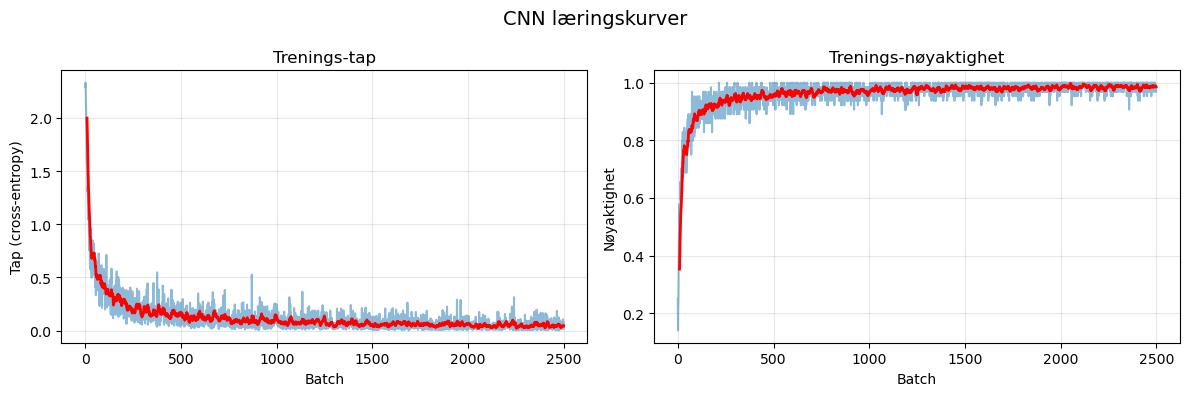

In [21]:
# === Vis læringskurver ===

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Tap
axes[0].plot(modell.trenings_tap, alpha=0.5)
# Glidende gjennomsnitt
vindu = 10
glidende = np.convolve(modell.trenings_tap, np.ones(vindu)/vindu, mode='valid')
axes[0].plot(range(vindu-1, len(modell.trenings_tap)), glidende, 'r-', linewidth=2)
axes[0].set_xlabel('Batch')
axes[0].set_ylabel('Tap (cross-entropy)')
axes[0].set_title('Trenings-tap')
axes[0].grid(True, alpha=0.3)

# Nøyaktighet
axes[1].plot(modell.trenings_acc, alpha=0.5)
glidende_acc = np.convolve(modell.trenings_acc, np.ones(vindu)/vindu, mode='valid')
axes[1].plot(range(vindu-1, len(modell.trenings_acc)), glidende_acc, 'r-', linewidth=2)
axes[1].set_xlabel('Batch')
axes[1].set_ylabel('Nøyaktighet')
axes[1].set_title('Trenings-nøyaktighet')
axes[1].grid(True, alpha=0.3)

plt.suptitle('CNN læringskurver', fontsize=14)
plt.tight_layout()
plt.show()

---

## 5. Evaluer modellen

In [22]:
# === Evaluer på testdata ===

modell.eval()
alle_pred = []
alle_sann = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = modell(x)
        pred = torch.argmax(logits, dim=1)
        alle_pred.extend(pred.cpu().numpy())
        alle_sann.extend(y.cpu().numpy())

alle_pred = np.array(alle_pred)
alle_sann = np.array(alle_sann)

# Klassifikasjonsrapport
print("📊 Klassifikasjonsrapport:")
print("="*60)
print(classification_report(alle_sann, alle_pred,
                            target_names=[f'Siffer {i}' for i in range(10)]))

📊 Klassifikasjonsrapport:
              precision    recall  f1-score   support

    Siffer 0       0.99      0.99      0.99       393
    Siffer 1       0.99      0.99      0.99       448
    Siffer 2       0.99      0.98      0.98       408
    Siffer 3       1.00      0.98      0.99       412
    Siffer 4       0.98      0.99      0.98       366
    Siffer 5       0.98      0.99      0.99       365
    Siffer 6       0.99      0.99      0.99       399
    Siffer 7       0.97      0.99      0.98       431
    Siffer 8       0.97      0.97      0.97       382
    Siffer 9       0.98      0.98      0.98       396

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.99      0.98      0.98      4000



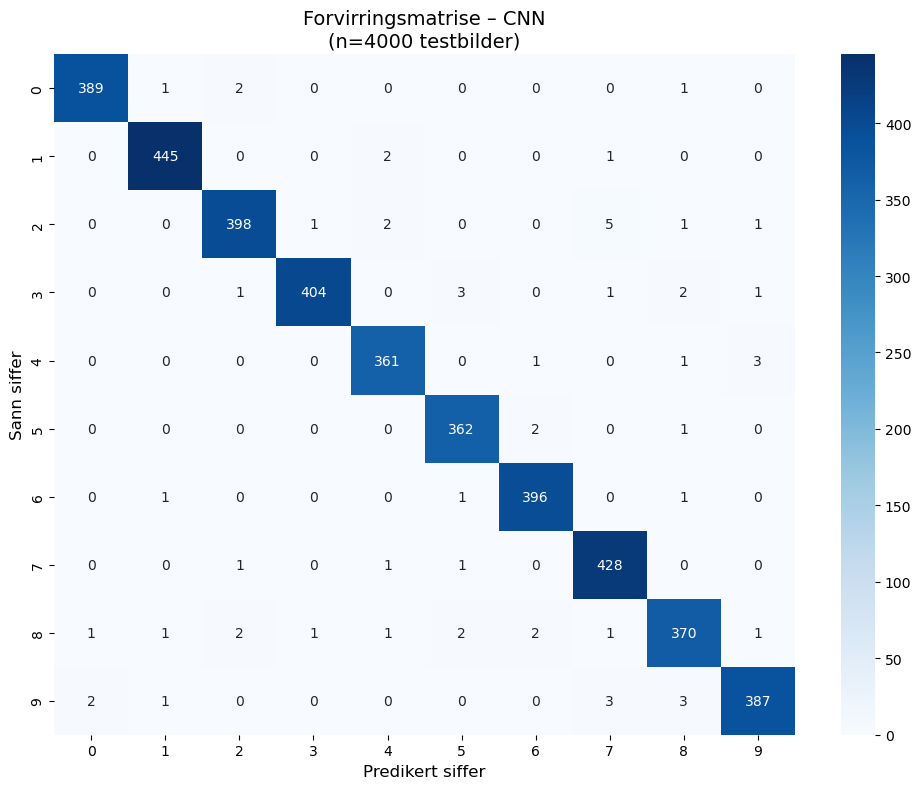


📊 CNN-resultater:
   Nøyaktighet: 98.5%
   Feilrate:    1.5%


In [23]:
# === Forvirringsmatrise ===

plt.figure(figsize=(10, 8))
cm = confusion_matrix(alle_sann, alle_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))

plt.title(f'Forvirringsmatrise – CNN\n(n={len(alle_sann)} testbilder)', fontsize=14)
plt.xlabel('Predikert siffer', fontsize=12)
plt.ylabel('Sann siffer', fontsize=12)
plt.tight_layout()
plt.show()

# Oppsummering
nøyaktighet = accuracy_score(alle_sann, alle_pred)
print(f"\n📊 CNN-resultater:")
print(f"   Nøyaktighet: {nøyaktighet:.1%}")
print(f"   Feilrate:    {1-nøyaktighet:.1%}")

---

## 6. Sammenligning av alle tre metoder

### Resultater på MNIST (5000 bilder)

📊 Modellsammenligning:
       Modell  Nøyaktighet Parametre Romlig struktur GPU nødvendig
Random Forest        0.920         -             Nei           Nei
 MLP (100,50)        0.970    84,060             Nei           Nei
          CNN        0.985   261,000              Ja      Anbefalt


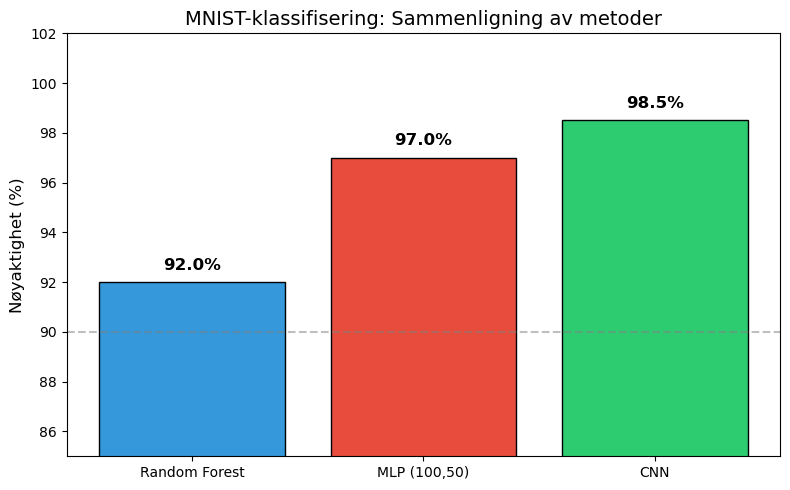

In [24]:
# === Sammenligning av modeller ===

# Typiske resultater (kan variere noe)
resultater = {
    'Modell': ['Random Forest', 'MLP (100,50)', 'CNN'],
    'Nøyaktighet': [0.92, 0.97, nøyaktighet],
    'Parametre': ['-', '84,060', '261,000'],
    'Romlig struktur': ['Nei', 'Nei', 'Ja'],
    'GPU nødvendig': ['Nei', 'Nei', 'Anbefalt']
}

df_sammenligning = pd.DataFrame(resultater)
print("📊 Modellsammenligning:")
print("="*70)
print(df_sammenligning.to_string(index=False))

# Visualiser
fig, ax = plt.subplots(figsize=(8, 5))
farger = ['#3498db', '#e74c3c', '#2ecc71']
søyler = ax.bar(resultater['Modell'], [x*100 for x in resultater['Nøyaktighet']], 
                color=farger, edgecolor='black')

# Legg til prosent over søylene
for søyle, acc in zip(søyler, resultater['Nøyaktighet']):
    ax.text(søyle.get_x() + søyle.get_width()/2, søyle.get_height() + 0.5,
            f'{acc:.1%}', ha='center', fontsize=12, fontweight='bold')

ax.set_ylabel('Nøyaktighet (%)', fontsize=12)
ax.set_title('MNIST-klassifisering: Sammenligning av metoder', fontsize=14)
ax.set_ylim(85, 102)
ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='90% terskel')
plt.tight_layout()
plt.show()

### Viktig: Datamengdens betydning for CNN

#### Hvorfor CNN noen ganger presterer dårligere enn MLP med lite data

Med **5000 bilder** kan CNN faktisk prestere *dårligere* enn MLP. Her er forklaringen:

```
┌─────────────────────────────────────────────────────────────────┐
│  Modell          Parametre    Data per parameter               │
├─────────────────────────────────────────────────────────────────┤
│  Random Forest   -            Trær, ikke parametre              │
│  MLP             ~84,000      5000/84000 = 0.06 bilder/param    │
│  CNN             ~261,000     5000/261000 = 0.02 bilder/param   │
└─────────────────────────────────────────────────────────────────┘
```

**CNN har 3× flere parametre** men samme datamengde → høyere risiko for **overfitting**!

#### Forventet effekt av datamengde

```
                    Typisk nøyaktighet ved ulike datamengder
┌──────────────┬─────────┬─────────┬──────────┬──────────┬──────────┐
│  Modell      │  1,000  │  5,000  │  10,000  │  30,000  │  60,000  │
├──────────────┼─────────┼─────────┼──────────┼──────────┼──────────┤
│ Random Forest│   88%   │   92%   │   93%    │   94%    │   95%    │
│ MLP          │   92%   │   97%   │  97.5%   │   98%    │  98.5%   │
│ CNN          │   85%   │   96%   │   98%    │   99%    │  99.5%   │
└──────────────┴─────────┴─────────┴──────────┴──────────┴──────────┘
```

**Hovedpoeng**: CNN "krysser" MLP ved ~10,000+ bilder og viser sin styrke med større datasett.

#### Andre faktorer som påvirker CNN-ytelse

| Faktor | Beskrivelse | Løsning |
|--------|-------------|--------|
| **Treningsepoker** | CNN trenger flere iterasjoner | Øk `max_epochs` |
| **Data augmentation** | Kunstig utvide datasettet | Rotasjon, flipping |
| **Bildestørrelse** | 28×28 er enkelt for MLP | CNN skinner på større bilder |
| **Arkitektur** | For kompleks modell → overfitting | Enklere nettverk, mer dropout |

#### Medisinsk perspektiv på modellvalg

| Datamengde | Anbefalt modell | Begrunnelse |
|------------|-----------------|-------------|
| **< 5,000** | MLP eller RF | CNN overfitter |
| **5,000-20,000** | Kan prøve begge | CNN begynner å vinne |
| **> 20,000** | CNN | Klart beste valg for bilder |
| **Store bilder** | CNN alltid | Uansett datamengde |

> 💡 **Lærdom**: I medisinsk AI med begrenset data (f.eks. sjeldne sykdommer), kan enklere modeller faktisk prestere bedre!

---

## 7. Medisinsk drøfting: Falske positive og negative

### Siffer 8 – et «vanskelig tilfelle»

I våre eksperimenter har **siffer 8** konsekvent hatt lavest klassifikasjonsnøyaktighet. La oss analysere dette fra et medisinsk perspektiv.

In [25]:
# === Analyser siffer 8 spesifikt ===

# Finn alle tilfeller der sann etikett er 8
idx_8_sann = np.where(alle_sann == 8)[0]
pred_for_8 = alle_pred[idx_8_sann]

# Finn alle tilfeller der prediksjon er 8
idx_8_pred = np.where(alle_pred == 8)[0]
sann_for_8_pred = alle_sann[idx_8_pred]

print("📊 Analyse av siffer 8:")
print("="*50)
print(f"\n🎯 Sanne 8-ere i testsettet: {len(idx_8_sann)}")
print(f"   Korrekt klassifisert som 8: {np.sum(pred_for_8 == 8)}")
print(f"   Feilklassifisert (falsk negativ): {np.sum(pred_for_8 != 8)}")

# Hva ble 8-ere feilklassifisert som?
feil_som = pred_for_8[pred_for_8 != 8]
if len(feil_som) > 0:
    print(f"\n   Feilklassifisert som: {dict(zip(*np.unique(feil_som, return_counts=True)))}")

print(f"\n🔍 Prediksjoner som 8: {len(idx_8_pred)}")
print(f"   Faktisk 8 (sann positiv): {np.sum(sann_for_8_pred == 8)}")
print(f"   Ikke 8 (falsk positiv): {np.sum(sann_for_8_pred != 8)}")

# Beregn metrikker
TP = np.sum((alle_sann == 8) & (alle_pred == 8))
FN = np.sum((alle_sann == 8) & (alle_pred != 8))
FP = np.sum((alle_sann != 8) & (alle_pred == 8))
TN = np.sum((alle_sann != 8) & (alle_pred != 8))

sensitivitet = TP / (TP + FN) if (TP + FN) > 0 else 0
spesifisitet = TN / (TN + FP) if (TN + FP) > 0 else 0
PPV = TP / (TP + FP) if (TP + FP) > 0 else 0  # Positiv prediktiv verdi

print(f"\n📈 Diagnostiske metrikker for siffer 8:")
print(f"   Sensitivitet (recall): {sensitivitet:.1%}")
print(f"   Spesifisitet:          {spesifisitet:.1%}")
print(f"   PPV (precision):       {PPV:.1%}")

📊 Analyse av siffer 8:

🎯 Sanne 8-ere i testsettet: 382
   Korrekt klassifisert som 8: 370
   Feilklassifisert (falsk negativ): 12

   Feilklassifisert som: {np.int64(0): np.int64(1), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(1), np.int64(4): np.int64(1), np.int64(5): np.int64(2), np.int64(6): np.int64(2), np.int64(7): np.int64(1), np.int64(9): np.int64(1)}

🔍 Prediksjoner som 8: 380
   Faktisk 8 (sann positiv): 370
   Ikke 8 (falsk positiv): 10

📈 Diagnostiske metrikker for siffer 8:
   Sensitivitet (recall): 96.9%
   Spesifisitet:          99.7%
   PPV (precision):       97.4%


### Medisinsk analogi: Hva om «8» var en kritisk diagnose?

Tenk deg at siffer **8** representerer en **alvorlig diagnose** (f.eks. kreft), mens andre siffer er godartede tilstander.

| Utfall | MNIST-analogi | Medisinsk konsekvens |
|--------|---------------|----------------------|
| **Sann positiv** | 8 → 8 | Korrekt kreftdiagnose → Behandling starter |
| **Falsk negativ** | 8 → 0,3,5... | Kreft misses! → Forsinket behandling |
| **Falsk positiv** | 0,3,5 → 8 | Falsk alarm → Unødvendig bekymring/biopsi |
| **Sann negativ** | Ikke 8 → Ikke 8 | Korrekt friskmelding |

### Hvorfor feiler modellene på 8?

```
     ┌───┐      ┌───┐      ┌───┐      ┌───┐
     │ 0 │      │ 3 │      │ 5 │      │ 8 │
     │ ○ │      │ ∋ │      │ S │      │ 8 │
     └───┘      └───┘      └───┘      └───┘
     Lukket     Åpne       Kurver     Lukket
     sirkel     kurver     og linjer  dobbel
```

Siffer **8** deler visuelle egenskaper med:
- **0**: Lukket form
- **3**: Kurver på høyre side
- **5**: S-lignende kurver
- **6/9**: Sirkler

### Valg av modell: Sensitivitet vs spesifisitet

I medisinsk diagnostikk må vi velge mellom:

| Strategi | Fokus | Konsekvens |
|----------|-------|------------|
| **Høy sensitivitet** | Fange alle syke | Flere falske positive (unødvendige tester) |
| **Høy spesifisitet** | Unngå falske alarmer | Risiko for å misse tilfeller |

#### Eksempel: Screening vs diagnostikk

```
SCREENING                      DIAGNOSTIKK
(første linje)                 (bekreftelse)
┌─────────────────┐           ┌─────────────────┐
│ Høy sensitivitet│           │ Høy spesifisitet│
│ (fange alle)    │     →     │ (bekrefte)      │
│                 │           │                 │
│ Random Forest?  │           │ CNN!            │
└─────────────────┘           └─────────────────┘
```

### Konklusjon fra våre eksperimenter

| Modell | Beste bruksområde |
|--------|-------------------|
| **Random Forest** | Rask baseline, tolkbar, begrenset data |
| **MLP** | Bedre nøyaktighet, ikke-bildedata |
| **CNN** | Bildedata, høyest nøyaktighet, GPU anbefalt |

In [26]:
# === Lagre modellen ===

modell_fil = data_mappe / 'mnist_cnn_modell.pt'
torch.save(modell.state_dict(), modell_fil)

print(f"✅ CNN-modell lagret til: {modell_fil}")
print(f"   Filstørrelse: {modell_fil.stat().st_size / 1e6:.2f} MB")

✅ CNN-modell lagret til: mnist_data/mnist_cnn_modell.pt
   Filstørrelse: 4.80 MB


---

## Oppsummering: Læringsreisen fullført!

### Hva vi har lært

| Notebook | Modell | Nøkkelinnsikt |
|----------|--------|---------------|
| **A4** | Random Forest | Baseline, tolkbar, rask |
| **A5** | MLP | Nevrale nett lærer representasjoner |
| **A6** | CNN | Romlig struktur gir best resultat |

### Hovedfunn

1. **CNN > MLP > RF** for bildeklassifikasjon
2. **Siffer 8** er konsekvent vanskeligst å klassifisere
3. **Romlig struktur** er nøkkelen til CNNs suksess
4. **Valg av modell** avhenger av bruksområde

### Klinisk relevans

```
┌─────────────────────────────────────────────────────────────┐
│  I medisinsk AI:                                            │
│                                                             │
│  • Falske negative = Misset diagnose → ALVORLIG             │
│  • Falske positive = Unødvendig oppfølging → Kostbart       │
│                                                             │
│  Balansen mellom sensitivitet og spesifisitet               │
│  må tilpasses den kliniske konteksten!                      │
└─────────────────────────────────────────────────────────────┘
```

> 💡 **Ta med deg**: AI-verktøy er støtte for, ikke erstatning for, klinisk vurdering!

---

## 🎯 Oppgaver

### Oppgave 1: Analyser en annen klasse
Gjenta analysen av siffer 8, men for siffer **4** eller **9**. Er de like vanskelige å klassifisere?

<details>
<summary>💡 Vis hint</summary>

```python
siffer = 4  # Endre til ønsket siffer
idx_sann = np.where(alle_sann == siffer)[0]
pred_for_siffer = alle_pred[idx_sann]
recall = np.sum(pred_for_siffer == siffer) / len(idx_sann)
print(f"Recall for siffer {siffer}: {recall:.1%}")
```

</details>

### Oppgave 2: Juster terskelen
I stedet for `argmax`, bruk sannsynligheter og juster terskelen for å øke sensitiviteten for siffer 8.

<details>
<summary>💡 Vis hint</summary>

```python
# Få sannsynligheter
modell.eval()
with torch.no_grad():
    logits = modell(X_test_t[:100])
    prob = F.softmax(logits, dim=1)

# Senk terskel for klasse 8
terskel_8 = 0.3  # I stedet for 0.5
pred_8 = prob[:, 8] > terskel_8
```

</details>

### Oppgave 3: Visualiser CNN-filtre
Visualiser de lærte filtrene i første konvolusjonslag.

<details>
<summary>💡 Vis løsning</summary>

```python
filtre = modell.conv1.weight.data.cpu().numpy()
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(filtre[i, 0], cmap='RdBu')
    ax.axis('off')
plt.suptitle('CNN-filtre (første lag)')
plt.show()
```

</details>

### Oppsummering: PyTorch vs Lightning

| Aspekt | Ren PyTorch | PyTorch Lightning |
|--------|-------------|-------------------|
| **Treningsløkke** | Manuell (for-løkke) | Automatisk (`trainer.fit()`) |
| **Kode-struktur** | Fritt, kan bli rotete | Organisert i metoder |
| **Logging** | Manuell `print()` | Innebygd `self.log()` |
| **GPU-støtte** | Manuell `.to(device)` | Automatisk |
| **Checkpointing** | Manuell lagring | Innebygd |

**Når bruke hva?**
- 🔧 **Ren PyTorch**: For å forstå hva som skjer, eksperimentering, enkle oppgaver
- ⚡ **Lightning**: For produksjonskode, større prosjekter, reproduserbar forskning

### Plattform-spesifikke notater

| Plattform | Akselerator | `num_workers` i DataLoader |
|-----------|-------------|--------------------------|
| **Apple Silicon** (M1–M4) | MPS (Metal) | Må være `0` pga. multiprocessing-begrensninger |
| **NVIDIA GPU** | CUDA | Kan være `>0` for parallell lasting |
| **CPU** | – | Kan være `>0` |

> 💡 **Tips:** PyTorch støtter Apple Silicon via **MPS** (Metal Performance Shaders). Lightning oppdager dette automatisk!

---

*Resten av denne notebooken bruker disse verktøyene på EEG-data for epilepsi-deteksjon!*
